# Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Loading the scrapped datasets

In [2]:
DATA_DIR = "data/lyrics/"

In [10]:
df = pd.read_json(DATA_DIR + "fr_70_84.json")
df['lyrics_state'] = df['lyrics_state'].apply(lambda state: 0 if state == "missing" else 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4515 entries, 0 to 4514
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist        4515 non-null   object
 1   title         4515 non-null   object
 2   lyrics        3503 non-null   object
 3   lyrics_state  4515 non-null   int64 
 4   year          4515 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 211.6+ KB


In [54]:
df.head()

,artist,title,lyrics,lyrics_state,year
0,adamo,gagner du temps / et après,Histoire comique des États et Empires de la Lu...,1,1970
1,adamo,les belles dames,Zone LyricsÀ la fin tu es las de ce monde anci...,1,1970
2,adamo,va mon bateau,Qu’on m’appelle Adamé LyricsVa falloir démêler...,1,1970
3,adamo,sois heureuse rose,Histoire comique des États et Empires de la Lu...,1,1970
4,alain barrière,je l'attendais,None,0,1970


## Singles per year

Text(0, 0.5, 'Number of artists')

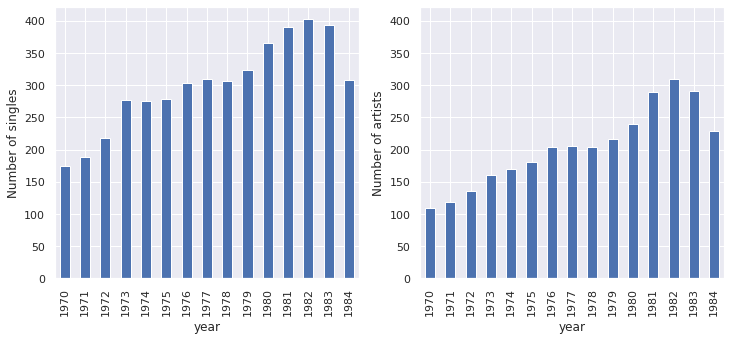

In [81]:
yearly_df = df.groupby('year')
plt.figure(figsize=(12, 5))

# Plots the number of titles per year
ax = plt.subplot(121)
yearly_titles = yearly_df.count()['title']
yearly_titles.plot.bar()
ylim = ax.get_ylim()
plt.ylabel('Number of singles')

# Plots the number of unique artists per year
ax = plt.subplot(122)
yearly_df.artist.nunique().plot.bar()
# Sets the same ylim as for the first plot
ax.set_ylim(ylim)
plt.ylabel('Number of artists')

## Missing data

In [83]:
yearly_df = df.groupby('year')
yearly_titles = yearly_df.count()['title']

yearly_complete_lyrics = yearly_df.sum()['lyrics_state']
yearly_missing_proportion = 1 - (yearly_complete_lyrics / yearly_titles)

yearly_df = pd.DataFrame({'titles_count': yearly_titles, 'complete': yearly_complete_lyrics, 'missing': yearly_titles - yearly_complete_lyrics,
                          'missing_proportion': yearly_missing_proportion})
yearly_df.head()

,titles_count,complete,missing,missing_proportion
year,,,,
1970,175,133,42,0.240000
1971,188,137,51,0.271277
1972,218,161,57,0.261468
1973,277,215,62,0.223827
1974,276,203,73,0.264493


Text(0, 0.5, 'Proportion of missing lyrics')

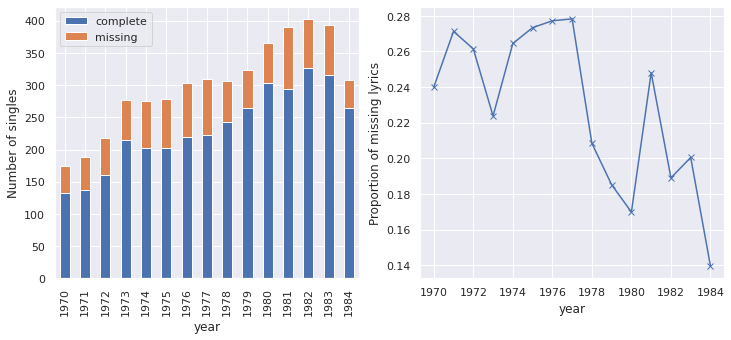

In [96]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
yearly_df[['complete', 'missing']].plot.bar(stacked=True, ax=ax)
plt.ylabel('Number of singles')

plt.subplot(122)
yearly_df['missing_proportion'].plot(style='-x')
plt.ylabel("Proportion of missing lyrics")

In [11]:
data = pd.read_json('data/lyrics/all_lyrics.json')
data.head()

,index,year,artist,title,lyrics,country
0,0,1970,adamo,gagner du temps / et après,Histoire comique des États et Empires de la Lu...,da
1,1,1970,adamo,les belles dames,Zone LyricsÀ la fin tu es las de ce monde anci...,da
2,2,1970,adamo,va mon bateau,Qu’on m’appelle Adamé LyricsVa falloir démêler...,da
3,3,1970,adamo,sois heureuse rose,Histoire comique des États et Empires de la Lu...,da
4,4,1970,alain barrière,je l'attendais,None,da
